<a href="https://colab.research.google.com/github/joshdsolis/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module4-Model%20Diagnostics/Model_Diagnostics_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

In [0]:
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

In [104]:
##### Your Code Here #####

# Bringing in the data set
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')
pd.set_option('display.max_columns', 100)
df.head()
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [105]:
from sklearn.preprocessing import LabelEncoder

#Auto encodes any dataframe column of type category or object.
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df
df = dummyEncode(df)

Error encoding Alley
Error encoding MasVnrType
Error encoding BsmtQual
Error encoding BsmtCond
Error encoding BsmtExposure
Error encoding BsmtFinType1
Error encoding BsmtFinType2
Error encoding Electrical
Error encoding FireplaceQu
Error encoding GarageType
Error encoding GarageFinish
Error encoding GarageQual
Error encoding GarageCond
Error encoding PoolQC
Error encoding Fence
Error encoding MiscFeature


In [0]:
# Dropping some objects that can be dummy Encoded
df = df.drop(['Alley', 'MasVnrType', 'BsmtQual','BsmtCond',
              'BsmtExposure','BsmtFinType1','BsmtFinType2',
             'Electrical','FireplaceQu','GarageType',
             'GarageFinish','GarageQual','GarageCond',
             'PoolQC','Fence','MiscFeature'], axis=1)
df = df.fillna(df.mean())

In [107]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,196.0,2,4,2,706,0,150,856,1,0,1,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,2003.0,2,548,2,0,61,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,0.0,3,4,1,978,0,284,1262,1,0,1,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,1976.0,2,460,2,298,0,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,162.0,2,4,2,486,0,434,920,1,0,1,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,2001.0,2,608,2,0,42,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,0.0,3,4,0,216,0,540,756,1,2,1,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,1998.0,3,642,2,0,35,272,0,0,0,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,350.0,2,4,2,655,0,490,1145,1,0,1,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,2000.0,3,836,2,192,84,0,0,0,0,0,12,2008,8,4,250000


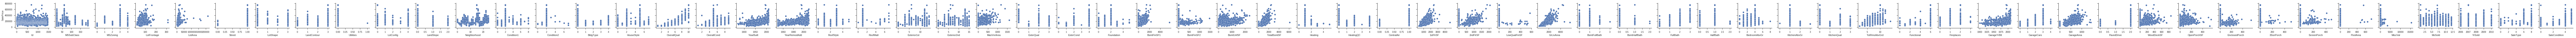

In [108]:
sns.set(style="ticks", color_codes=True)

# Generate a list of column headers not including price
x_columns = df.columns.drop('SalePrice')

# Only plot the scatterplot of x variables with our y variable
fig = sns.pairplot(data=df, y_vars=['SalePrice'], x_vars=x_columns)



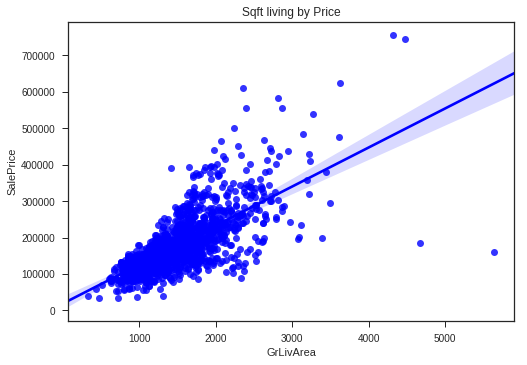

In [109]:
fig = sns.regplot(df.GrLivArea, df.SalePrice, color='blue').set_title('Sqft living by Price')

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [110]:
##### Your Code Here #####

df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [0]:
X = df[['OverallQual','MasVnrArea','BsmtFinSF1','TotalBsmtSF',
        '1stFlrSF','2ndFlrSF', 'GrLivArea','FullBath','TotRmsAbvGrd','WoodDeckSF',
         'OpenPorchSF']]

y = df['SalePrice']

In [112]:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     437.8
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        20:33:32   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1448   BIC:                         3.504e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.002e+05   6106.461    -16.406   

## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

In [0]:
##### Your Code Here #####
# The P-values test the null hypothesis which is 
# (the coefficients are equal to zero)

## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [114]:
# # Lets remove outliers 

print(df.shape)

df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

print(df.shape)

(1460, 65)
(689, 65)


## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

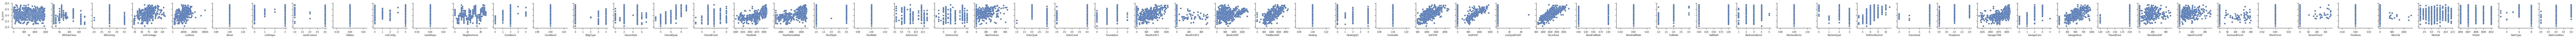

In [115]:
##### Your Code Here #####
df['ln_price'] = np.log(df['SalePrice'])

sns.set(style="ticks", color_codes=True)

# Generate a list of column headers not including price
x_columns = df.columns.drop(['SalePrice','ln_price'])

# Only plot the scatterplot of x variables with our y variable
fig = sns.pairplot(data=df, y_vars=['ln_price'], x_vars=x_columns)

In [118]:
X.head()

,const,OverallQual,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,WoodDeckSF,OpenPorchSF
0,1.0,7,196.0,706,856,856,854,1710,2,8,0,61
1,1.0,6,0.0,978,1262,1262,0,1262,2,6,298,0
2,1.0,7,162.0,486,920,920,866,1786,2,6,0,42
3,1.0,7,0.0,216,756,961,756,1717,1,7,0,35
4,1.0,8,350.0,655,1145,1145,1053,2198,2,9,192,84


In [123]:
X = df[['OverallQual','MasVnrArea','BsmtFinSF1','TotalBsmtSF',
        '1stFlrSF','2ndFlrSF', 'GrLivArea','FullBath','TotRmsAbvGrd','WoodDeckSF',
         'OpenPorchSF']]

y = df['ln_price']

# This is like using np.ones to add a vector of ones
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     364.5
Date:                Thu, 17 Jan 2019   Prob (F-statistic):          8.77e-276
Time:                        20:45:59   Log-Likelihood:                 467.42
No. Observations:                 689   AIC:                            -910.8
Df Residuals:                     677   BIC:                            -856.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.5961      0.033    322.176   

## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [120]:
##### Your Code Here #####
from statsmodels.stats.outliers_influence import variance_inflation_factor

print(X.columns, '\n\n')

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

Index(['const', 'OverallQual', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'WoodDeckSF', 'OpenPorchSF'],
      dtype='object') 


[48.57684046201428, 2.512823954029988, 1.275362028648799, 1.225552223654894, 5.099483559002027, 29173.445159330036, 47796.045086375874, 50162.685845152075, 2.4258780751382845, 3.649638492565563, 1.076330801995022, 1.2466999851320537]


In [121]:
X = df[['OverallQual', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF',
       'FullBath', 'TotRmsAbvGrd',
       'WoodDeckSF', 'OpenPorchSF']]

y = df['ln_price']

# This is like using np.ones to add a vector of ones
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     427.7
Date:                Thu, 17 Jan 2019   Prob (F-statistic):          1.69e-259
Time:                        20:41:50   Log-Likelihood:                 419.99
No. Observations:                 689   AIC:                            -822.0
Df Residuals:                     680   BIC:                            -781.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.5085      0.032    325.124   

The coefficients for the variable remaining in X do match up with my intuition. OverallQual and FullBath are the ones with the largest coefficients.

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

In [126]:
##### Your Code Here #####
X = df[['OverallQual','MasVnrArea','BsmtFinSF1','TotalBsmtSF',
        '1stFlrSF','2ndFlrSF', 'GrLivArea','FullBath','TotRmsAbvGrd','WoodDeckSF',
         'OpenPorchSF']]



no_const = X
no_const.corr()

,OverallQual,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,WoodDeckSF,OpenPorchSF
OverallQual,1.000000,0.402080,0.052929,0.502962,0.473399,0.281537,0.633881,0.676169,0.504789,0.218711,0.344862
MasVnrArea,0.402080,1.000000,0.160832,0.313752,0.299009,0.126220,0.350019,0.241651,0.264239,0.128955,0.197825
BsmtFinSF1,0.052929,0.160832,1.000000,0.335990,0.292292,-0.224484,0.002769,-0.048789,-0.096167,0.112627,0.069139
TotalBsmtSF,0.502962,0.313752,0.335990,1.000000,0.867763,-0.339718,0.326957,0.363021,0.214836,0.172929,0.212246
1stFlrSF,0.473399,0.299009,0.292292,0.867763,1.000000,-0.356906,0.411386,0.394653,0.270839,0.171072,0.206829
2ndFlrSF,0.281537,0.126220,-0.224484,-0.339718,-0.356906,1.000000,0.704595,0.400664,0.652235,0.067657,0.257771
GrLivArea,0.633881,0.350019,0.002769,0.326957,0.411386,0.704595,1.000000,0.690607,0.841928,0.195925,0.408844
FullBath,0.676169,0.241651,-0.048789,0.363021,0.394653,0.400664,0.690607,1.000000,0.579339,0.203330,0.331752
TotRmsAbvGrd,0.504789,0.264239,-0.096167,0.214836,0.270839,0.652235,0.841928,0.579339,1.000000,0.139215,0.304345
WoodDeckSF,0.218711,0.128955,0.112627,0.172929,0.171072,0.067657,0.195925,0.203330,0.139215,1.000000,0.072354


## 2.3 If you have varaibles with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In [127]:
##### Your Code Here #####
X = df[['OverallQual', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF',
       'FullBath', 'TotRmsAbvGrd',
       'WoodDeckSF', 'OpenPorchSF']]

y = df['ln_price']

# This is like using np.ones to add a vector of ones
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     427.7
Date:                Thu, 17 Jan 2019   Prob (F-statistic):          1.69e-259
Time:                        20:49:15   Log-Likelihood:                 419.99
No. Observations:                 689   AIC:                            -822.0
Df Residuals:                     680   BIC:                            -781.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.5085      0.032    325.124   

The standard errors are about as small as they were before dropping. Maybe they are slightly smaller.

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [130]:
##### Your Code Here #####

X = df[['OverallQual', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF',
       'FullBath', 'TotRmsAbvGrd',
       'WoodDeckSF', 'OpenPorchSF','GrLivArea']]

y = df['ln_price']

# This is like using np.ones to add a vector of ones
X = sm.add_constant(X)

model = sm.OLS(y, X).fit(cov_type='HC3')
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     418.6
Date:                Thu, 17 Jan 2019   Prob (F-statistic):          2.93e-270
Time:                        20:57:03   Log-Likelihood:                 466.35
No. Observations:                 689   AIC:                            -912.7
Df Residuals:                     679   BIC:                            -867.4
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.6079      0.036    291.613   

Standard errors go slightly up.

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

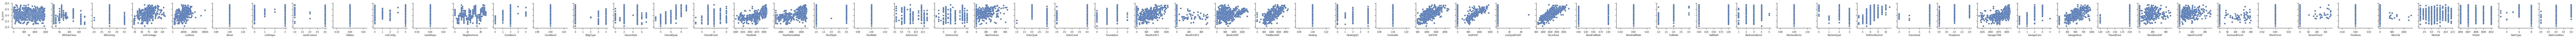

In [131]:
##### Your Code Here #####

sns.set(style="ticks", color_codes=True)

# Generate a list of column headers not including price
x_columns = df.columns.drop(['SalePrice', 'ln_price'])

# Only plot the scatterplot of x variables with our y variable
fig = sns.pairplot(data=df, y_vars=['ln_price'], x_vars=x_columns)

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


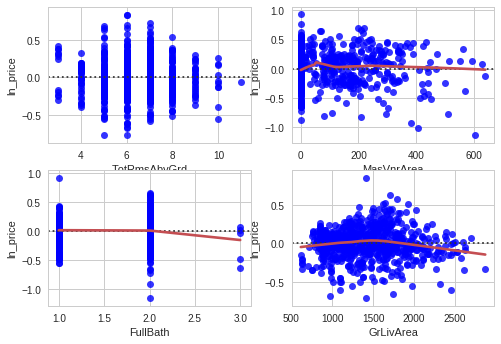

In [134]:
##### Your Code Here #####
sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=2, nrows=2)
sns.residplot(X['TotRmsAbvGrd'], y, lowess=True, color="r", ax=axs[0][0], scatter_kws={'color':'blue'})
sns.residplot(X['MasVnrArea'], y, lowess=True, color="r", ax=axs[0][1], scatter_kws={'color':'blue'})
sns.residplot(X['FullBath'], y, lowess=True, color="r", ax=axs[1][0], scatter_kws={'color':'blue'})
sns.residplot(X['GrLivArea'], y, lowess=True, color="r", ax=axs[1][1], scatter_kws={'color':'blue'})

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [135]:
##### Your Code Here #####
X['MasVnrAreaSq'] = X['MasVnrArea']**2
X['GrLivAreaSq'] = X['GrLivArea']**2
X = sm.add_constant(X)

model = sm.OLS(y, X).fit(cov_type='HC3')
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     338.2
Date:                Thu, 17 Jan 2019   Prob (F-statistic):          1.97e-266
Time:                        21:02:27   Log-Likelihood:                 466.36
No. Observations:                 689   AIC:                            -908.7
Df Residuals:                     677   BIC:                            -854.3
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.6025      0.061    173.118   

In [0]:
# The coefficients are about the same as the statsmodels library